In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI
import scarches as sca
import matplotlib.pyplot as plt
import seaborn as sns

Global seed set to 0
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


Get AnnData

In [15]:
adata = scv.datasets.pancreas()

In [16]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 21611 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [17]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


Get annotations

In [7]:
import gdown
url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
output = 'reactome.gmt'
gdown.download(url, output, quiet=False)

KeyboardInterrupt: 

In [18]:
data_path='data/Pancreas/'
sca.utils.add_annotations(adata, [data_path+'PanglaoDB_markers_27_Mar_2020.gmt',data_path+'reactome.gmt'], min_genes=12, clean=True)


In [19]:
#Remove all genes not present in annotations
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [20]:
#Filter out terms with less than 12 genes 
select_terms = adata.varm['I'].sum(0)>12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

Instantiate model and train

In [21]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)

Last Decoder layer: softmax


In [22]:
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]Init the group lasso proximal operator for the main terms.
INFO     velovi:                                                                                                   
         Number of deactivated terms: 0                                                                            
INFO     velovi: any_change: False                                                                                 
INFO     velovi:                                                                                                   
         Number of deactivated terms: 0                                                                            
INFO     velovi: any_change: False                                                                                 
Epoch 2/500:   0%|          | 1/500 [00:08<1:12:20,  8.70s/it, loss=1.13e+03, v_num=1, no. deactivated terms=0, validation_loss=951]INFO     velovi:                                             

Get latent representation

In [24]:
adata.obsm["latent"]=vae.get_latent()

In [25]:
sc.pp.neighbors(adata, use_rep='latent')

In [26]:
sc.tl.umap(adata)

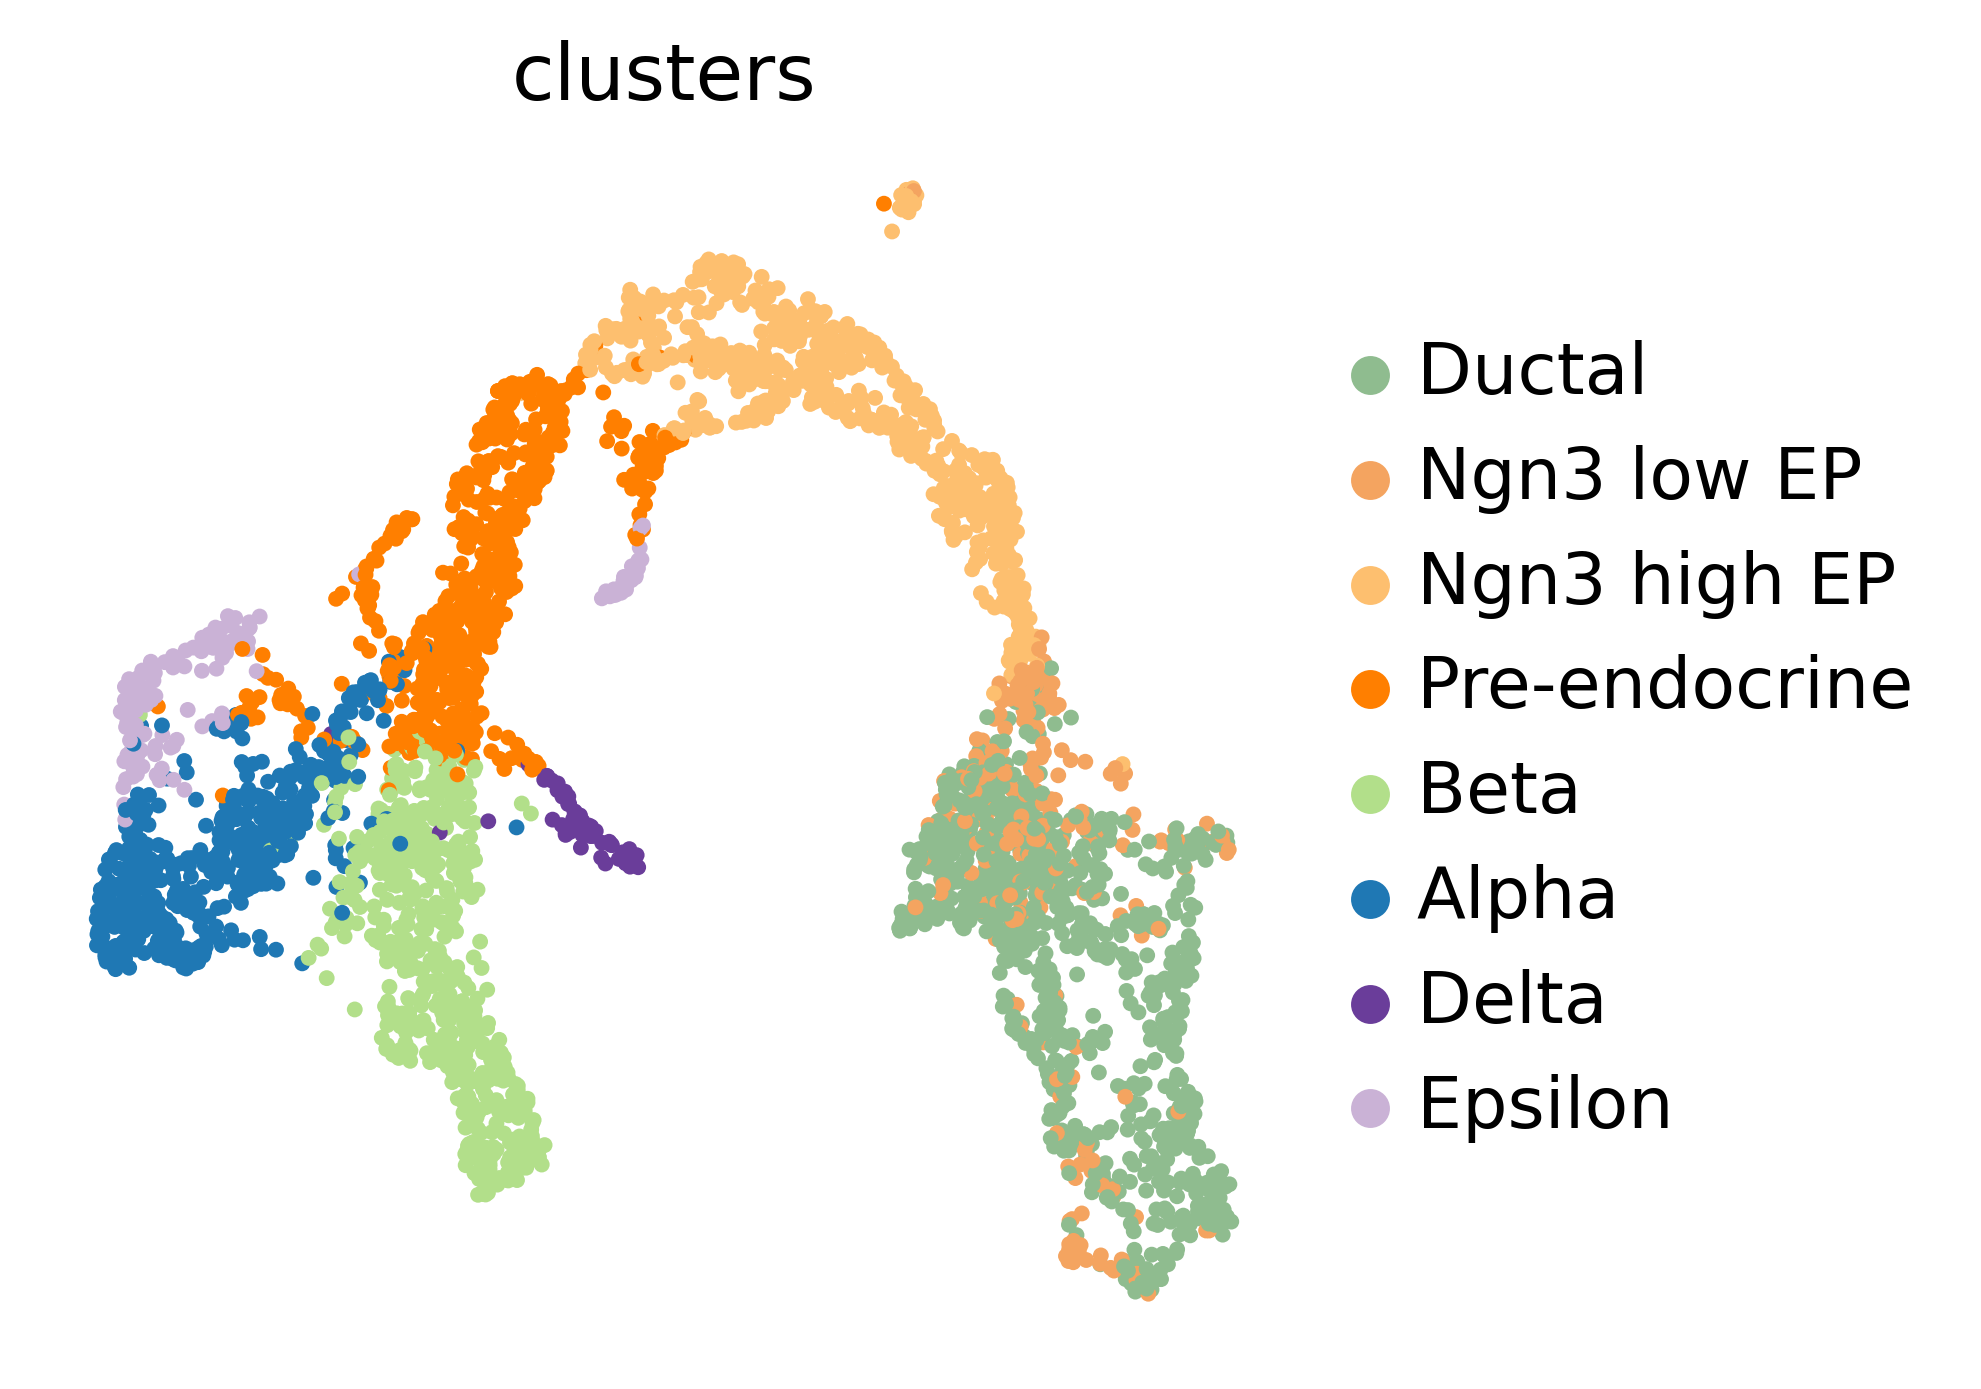

In [27]:
sc.pl.umap(adata, color='clusters', frameon=False)

Latent enrichment

In [ ]:
from scarches.models import EXPIMAP

Plot latent space to visualize gene programs

In [28]:
#get latent directions
vae.latent_directions()

In [29]:
terms = adata.uns['terms']
select_terms = ['METABOLISM_OF_CARBOHYDRATES', 'REGULATION_OF_INSULIN_SECRETIO',]
idx = [terms.index(term) for term in select_terms]

In [30]:
latents = (adata.obsm["latent"]*adata.uns['directions'])[:, idx]

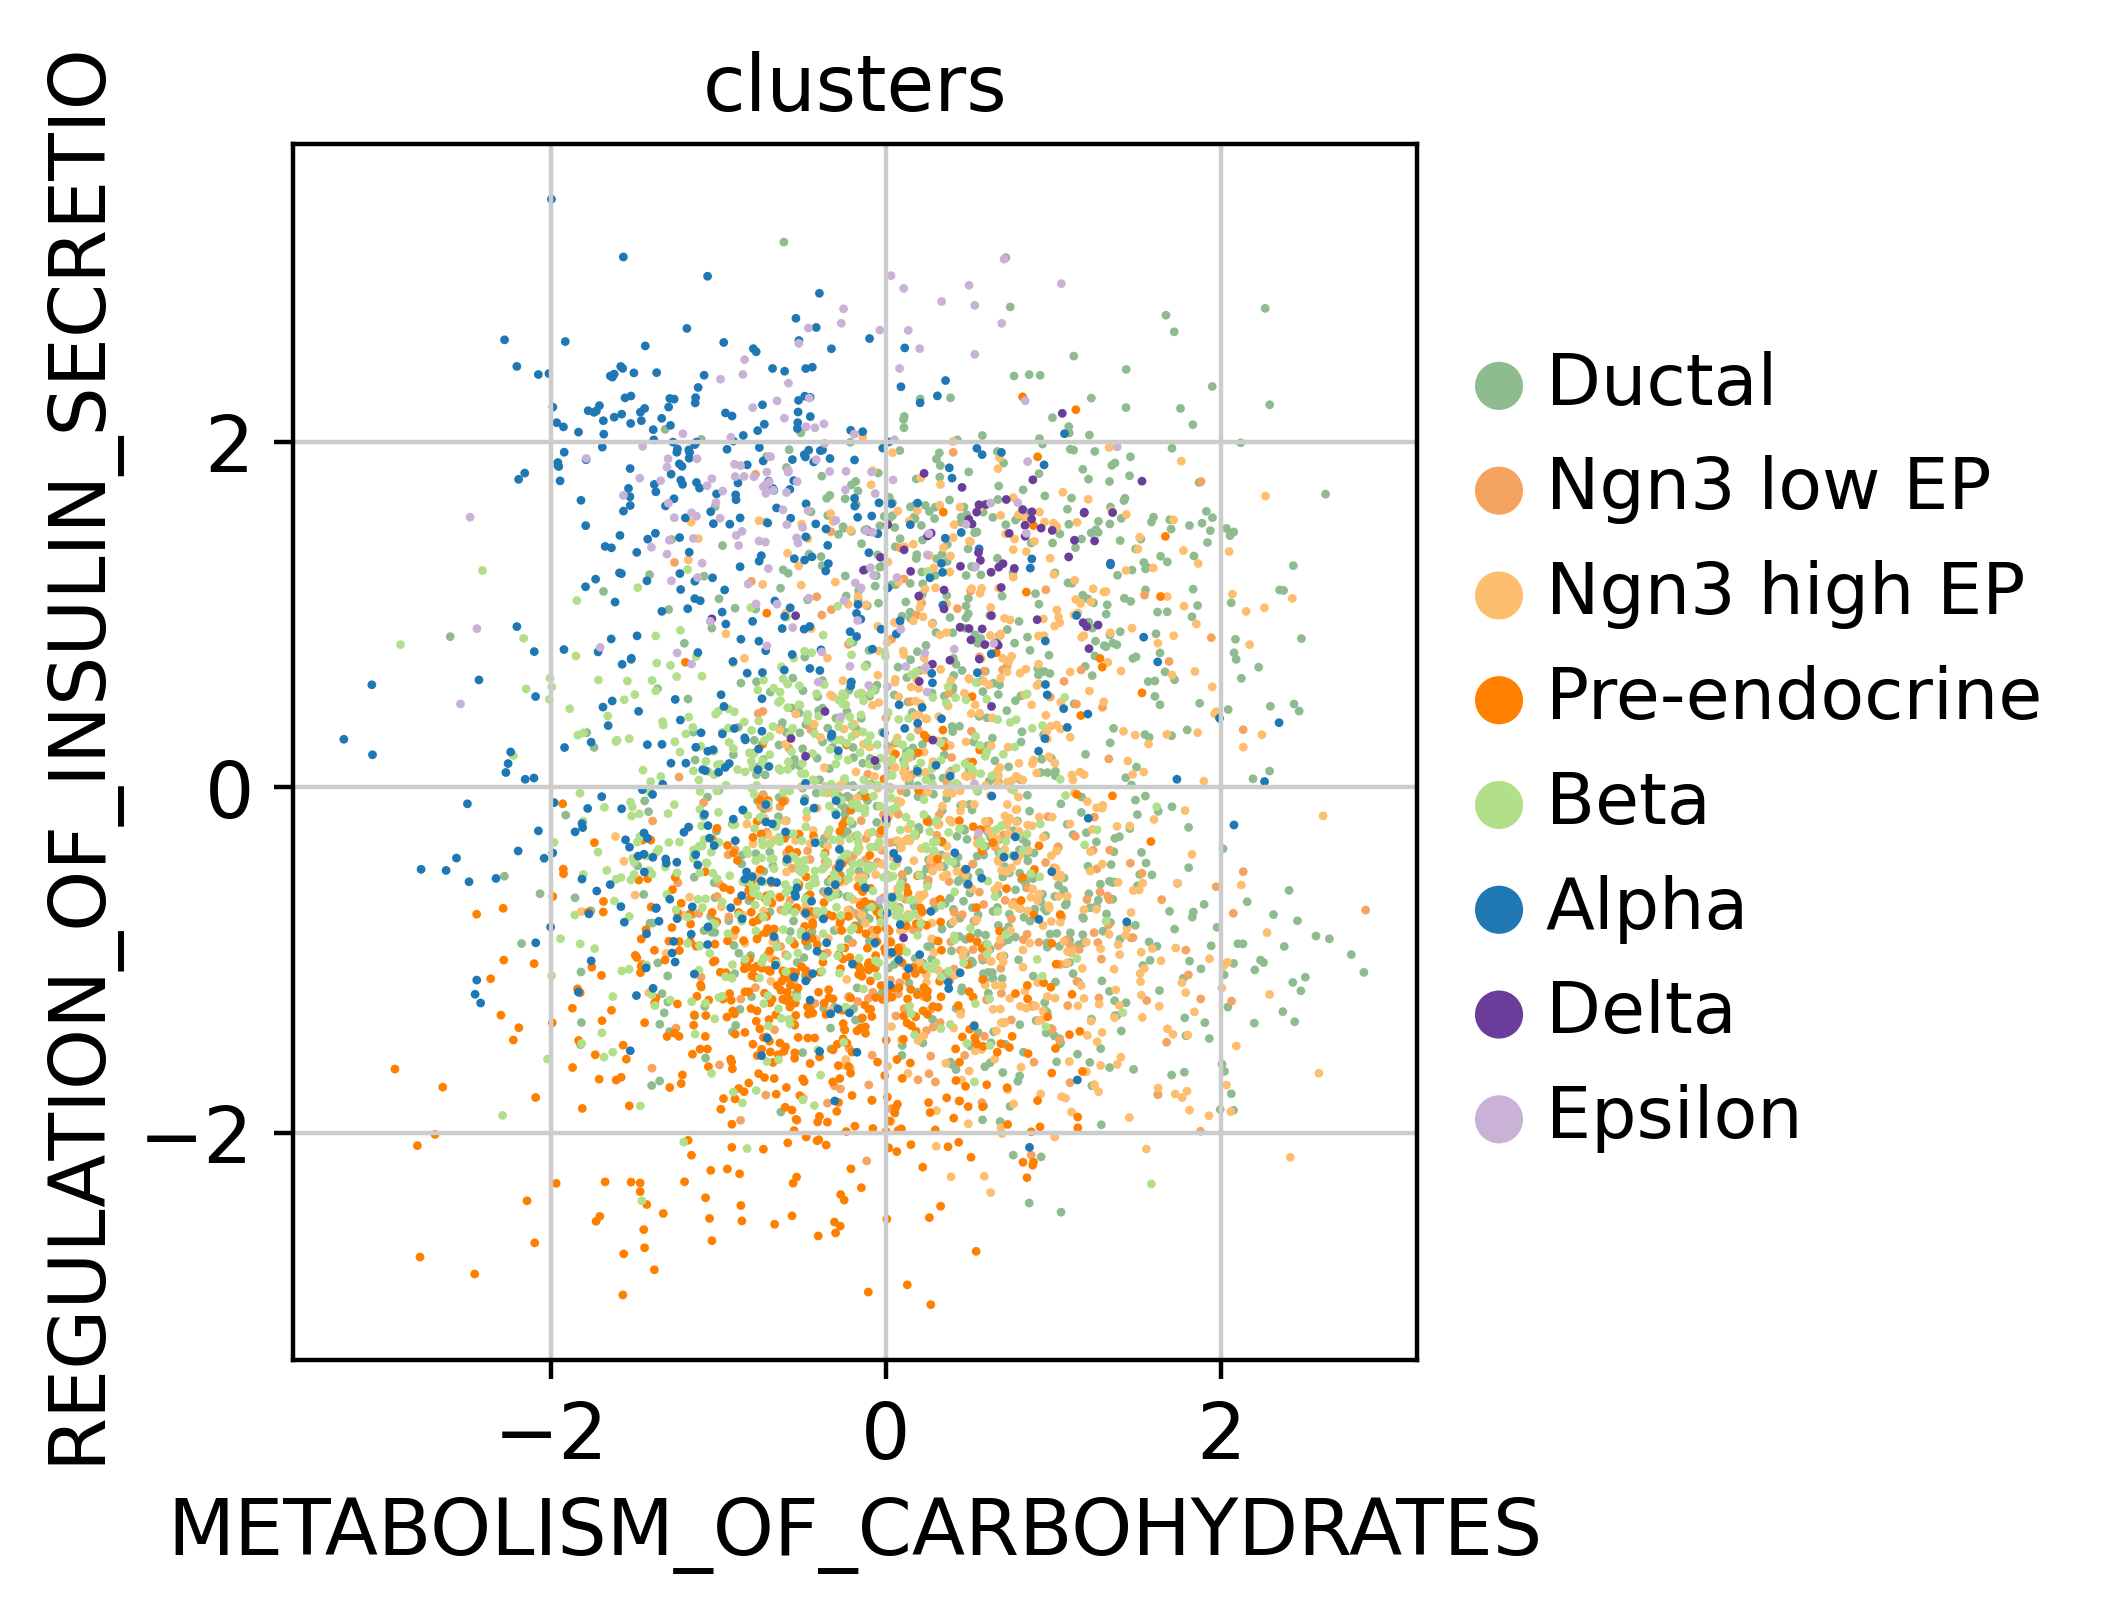

In [31]:
adata.obs['METABOLISM_OF_CARBOHYDRATES'] = latents[:, 0]
adata.obs['REGULATION_OF_INSULIN_SECRETIO'] = latents[:, 1]

sc.pl.scatter(adata, x='METABOLISM_OF_CARBOHYDRATES', y='REGULATION_OF_INSULIN_SECRETIO', color='clusters', size=10, save="2.png")

Save trained model

In [23]:
vae.save('velo_interpret_double_panglao_reactome')

In [12]:
#Load model
vae=VELOVI.load('velo_interpret_1', adata)

INFO     File velo_interpret_1/model.pt already downloaded                                                         
mask: tensor([[0., 0., 1., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
 

In [13]:
vae

VELOVI Model with the following params: 
n_hidden: 256, n_latent: 10, n_layers: 1, dropout_rate: 0.1
Training status: Trained

### Analysis of saved model

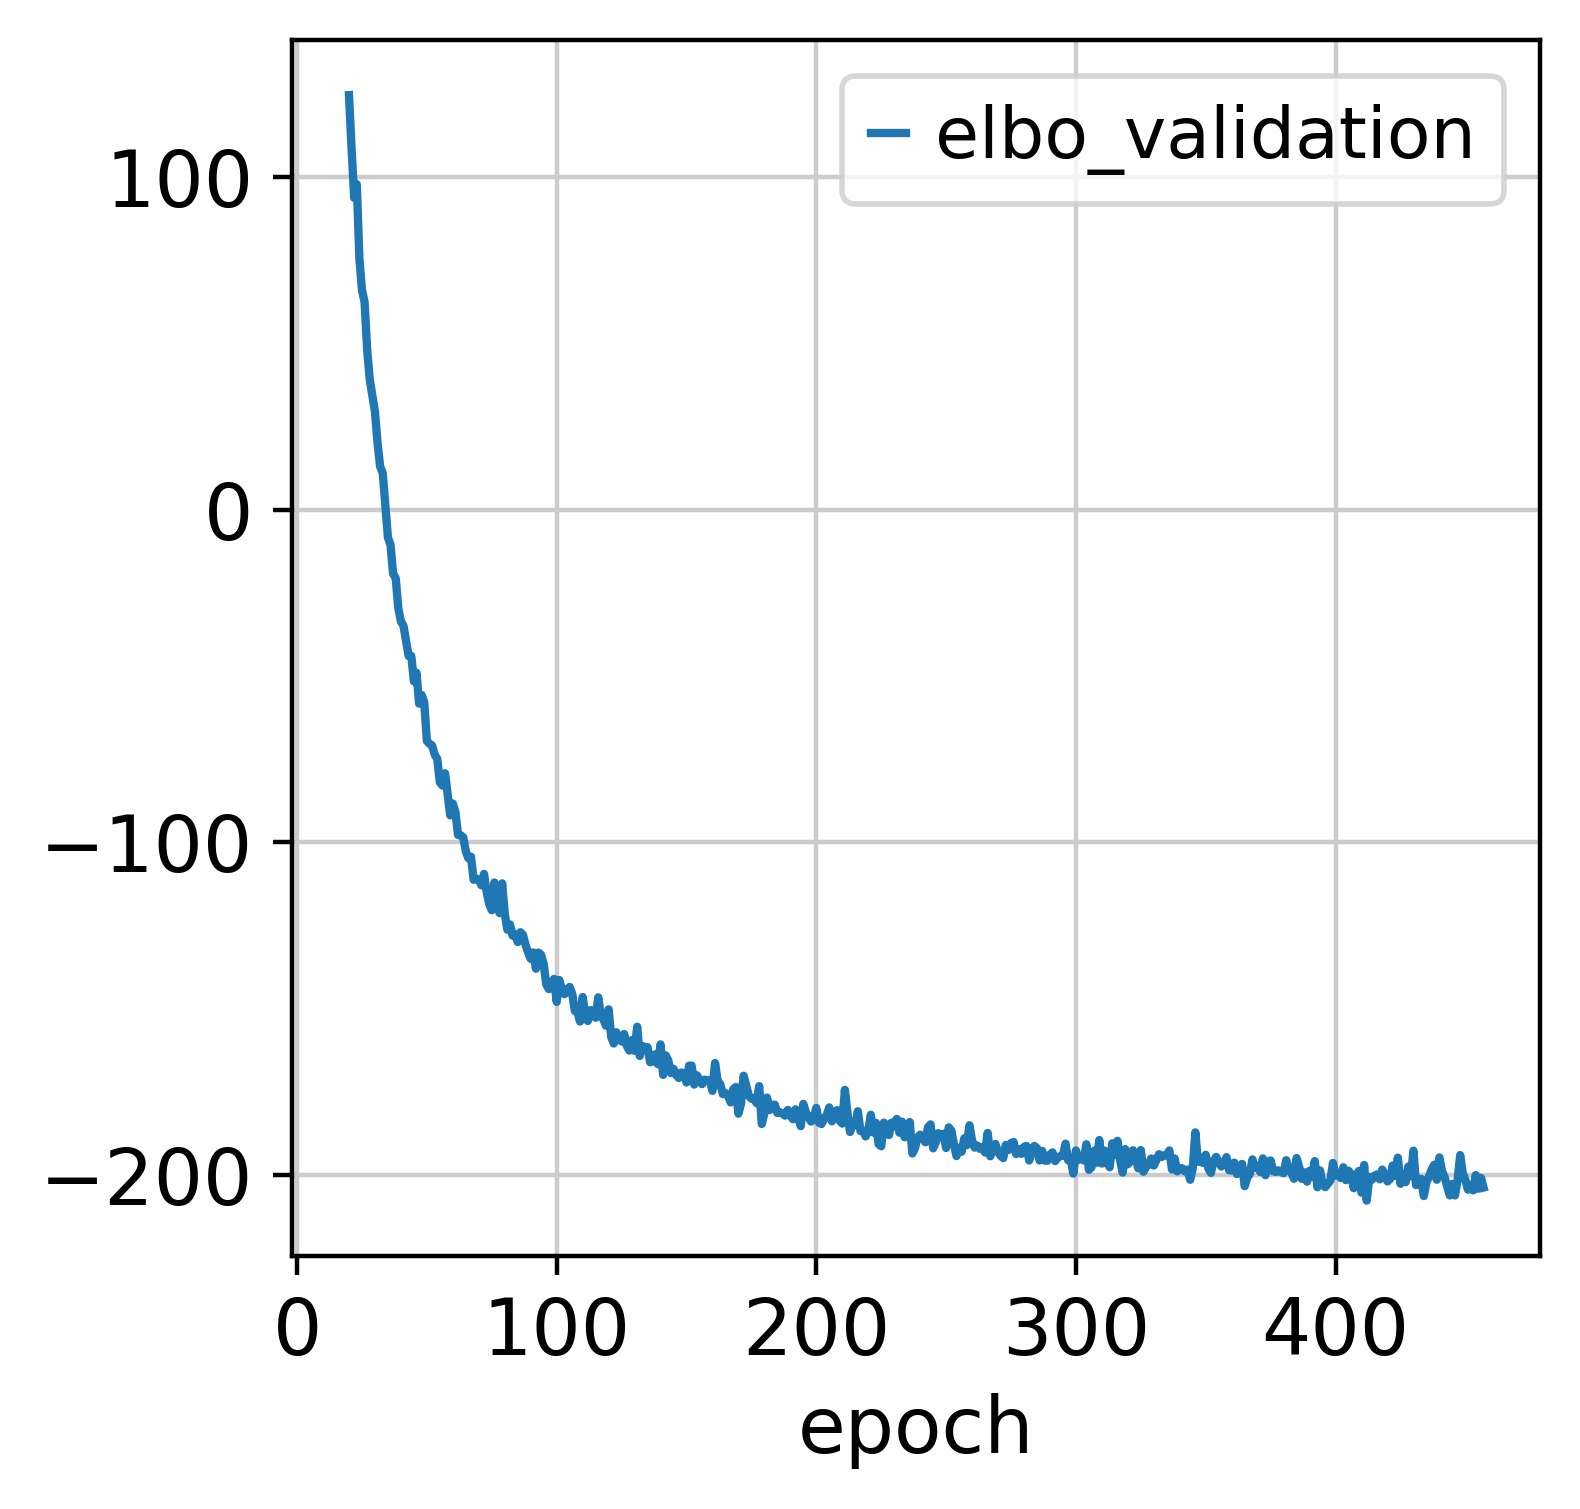

In [25]:
fig, ax = plt.subplots()
#vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()

Comparison velo_interpret to velo_orig

In [26]:
#Compare the MSE for unspliced and spliced counts between Velo_interpret and original 

import pandas as pd
pred=vae.get_expression_fit()
pred_s=pred[0]
pred_u=pred[1]
GT_s=adata.layers["Ms"]
GT_u=adata.layers["Mu"]
MSE_s=np.mean((pred_s-GT_s)**2, axis=0)
MSE_u=np.mean((pred_u-GT_u)**2, axis=0)

velo_interpret_MSE=pd.DataFrame([MSE_s,MSE_u]).T

#Read in saved MSE from velovi_orig
velo_orig_MSE=pd.read_csv("MSE_velovi_orig.csv", index_col="index")

#Calculate log10 MSE ratios
log10MSE_s=np.log10(velo_orig_MSE["0"]/velo_interpret_MSE[0])
log10MSE_u=np.log10(velo_orig_MSE["1"]/velo_interpret_MSE[1])
log10MSE_s=log10MSE_s.dropna()
log10MSE_u=log10MSE_u.dropna()

#Combine MSE for spliced and unspliced into 1 dataframe
MSE_combined=pd.DataFrame([log10MSE_s,log10MSE_u]).T
MSE_combined=MSE_combined.rename(columns={0:"spliced",1:"unspliced"})

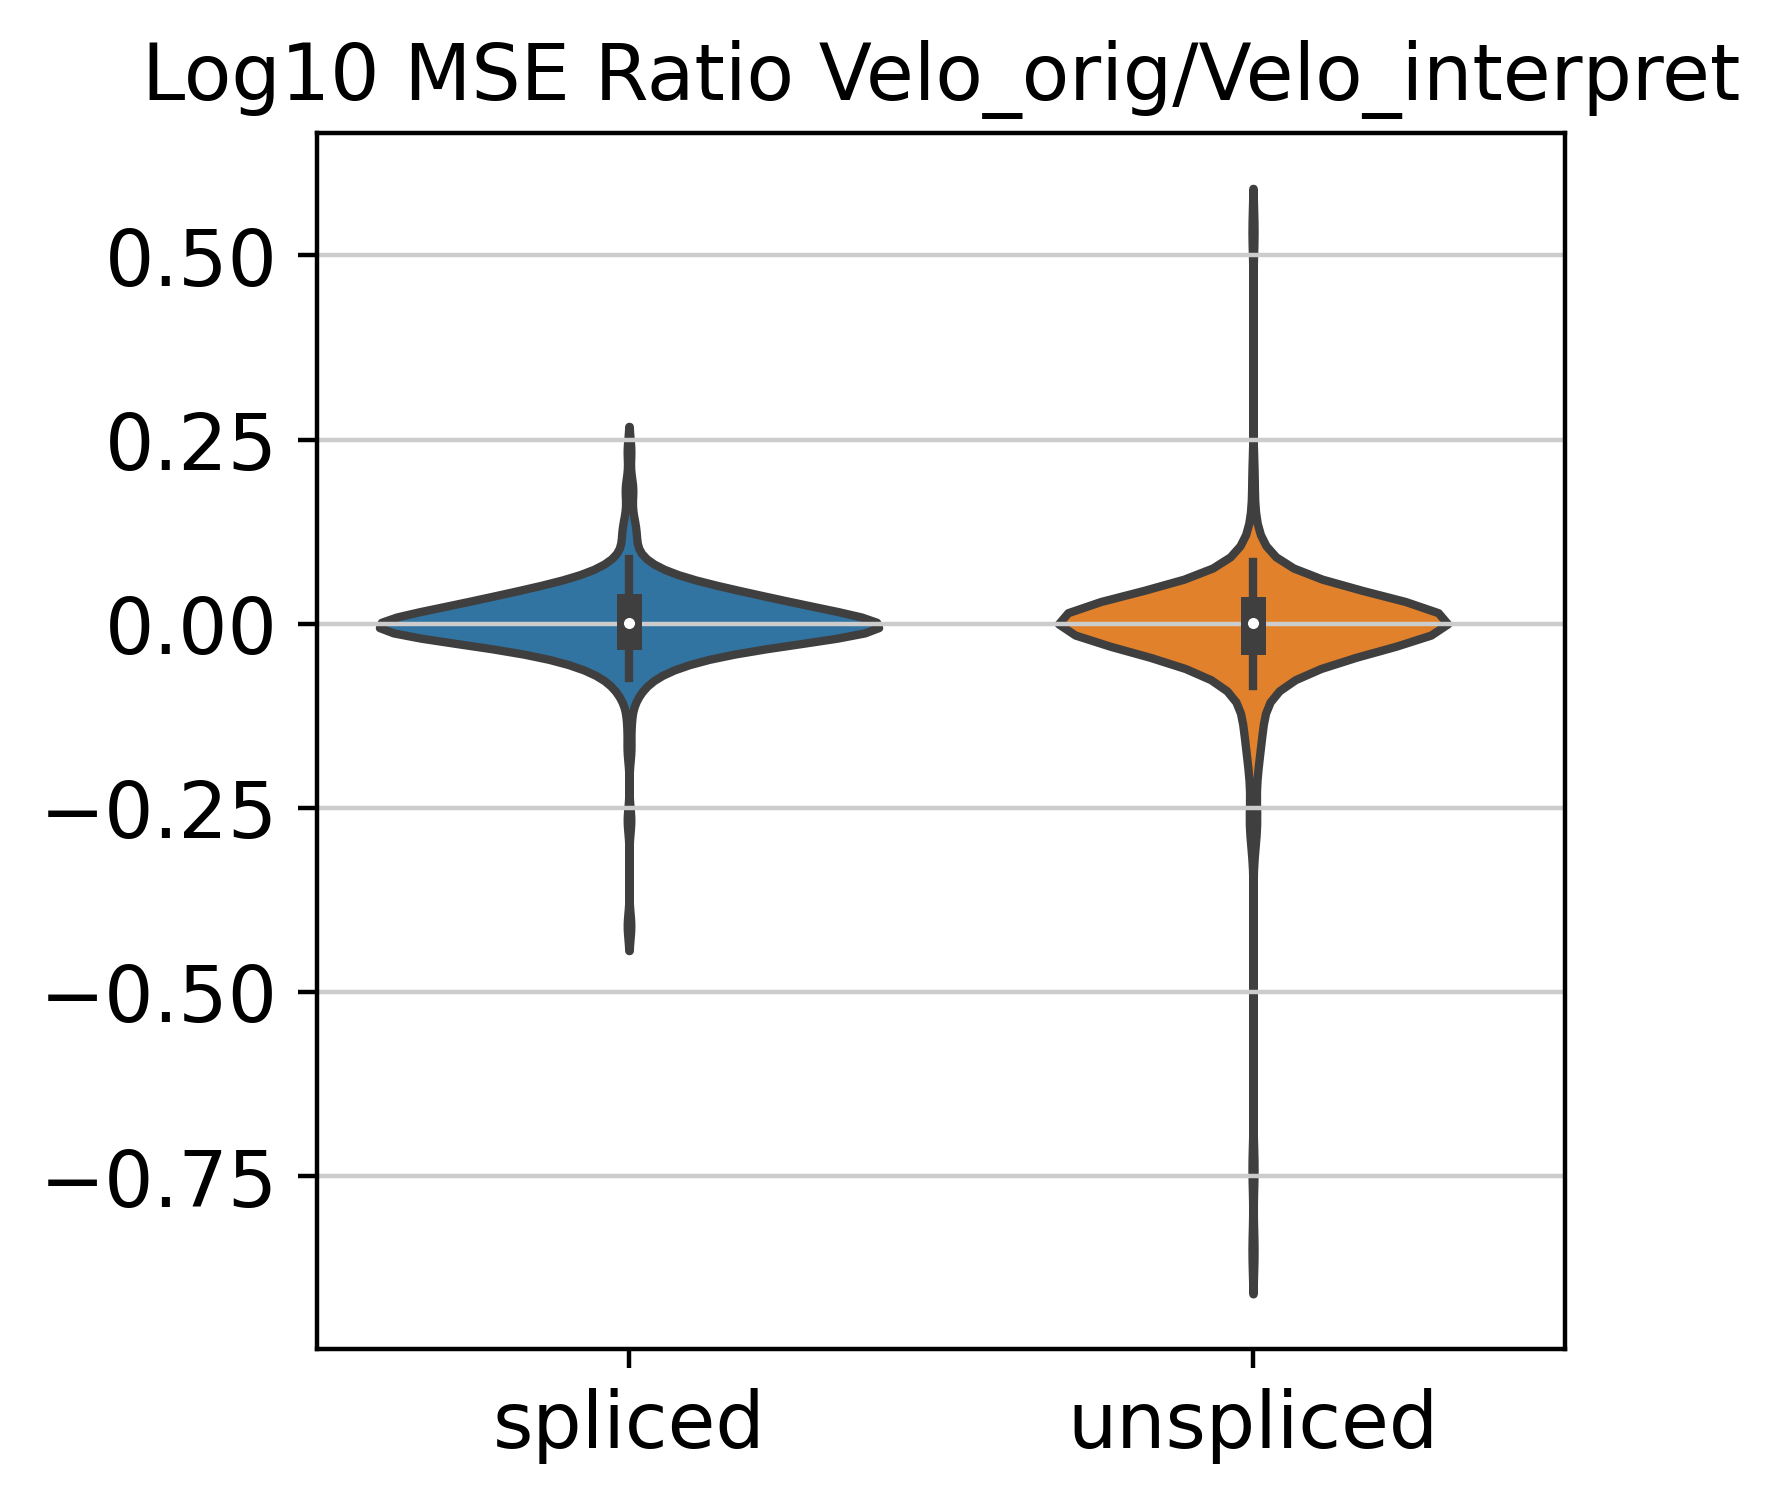

In [28]:
#Get violin plot of log10 MSEs
ax=sns.violinplot(data=MSE_combined)
ax.set_title("Log10 MSE Ratio Velo_orig/Velo_interpret")
MSE_fig=ax.get_figure()
MSE_fig.savefig("figures/decoder2/log10MSE.png") 

Add outputs of velo_interpret to adata

In [15]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

Get Velocity graph

In [16]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_velocity_embedding.png


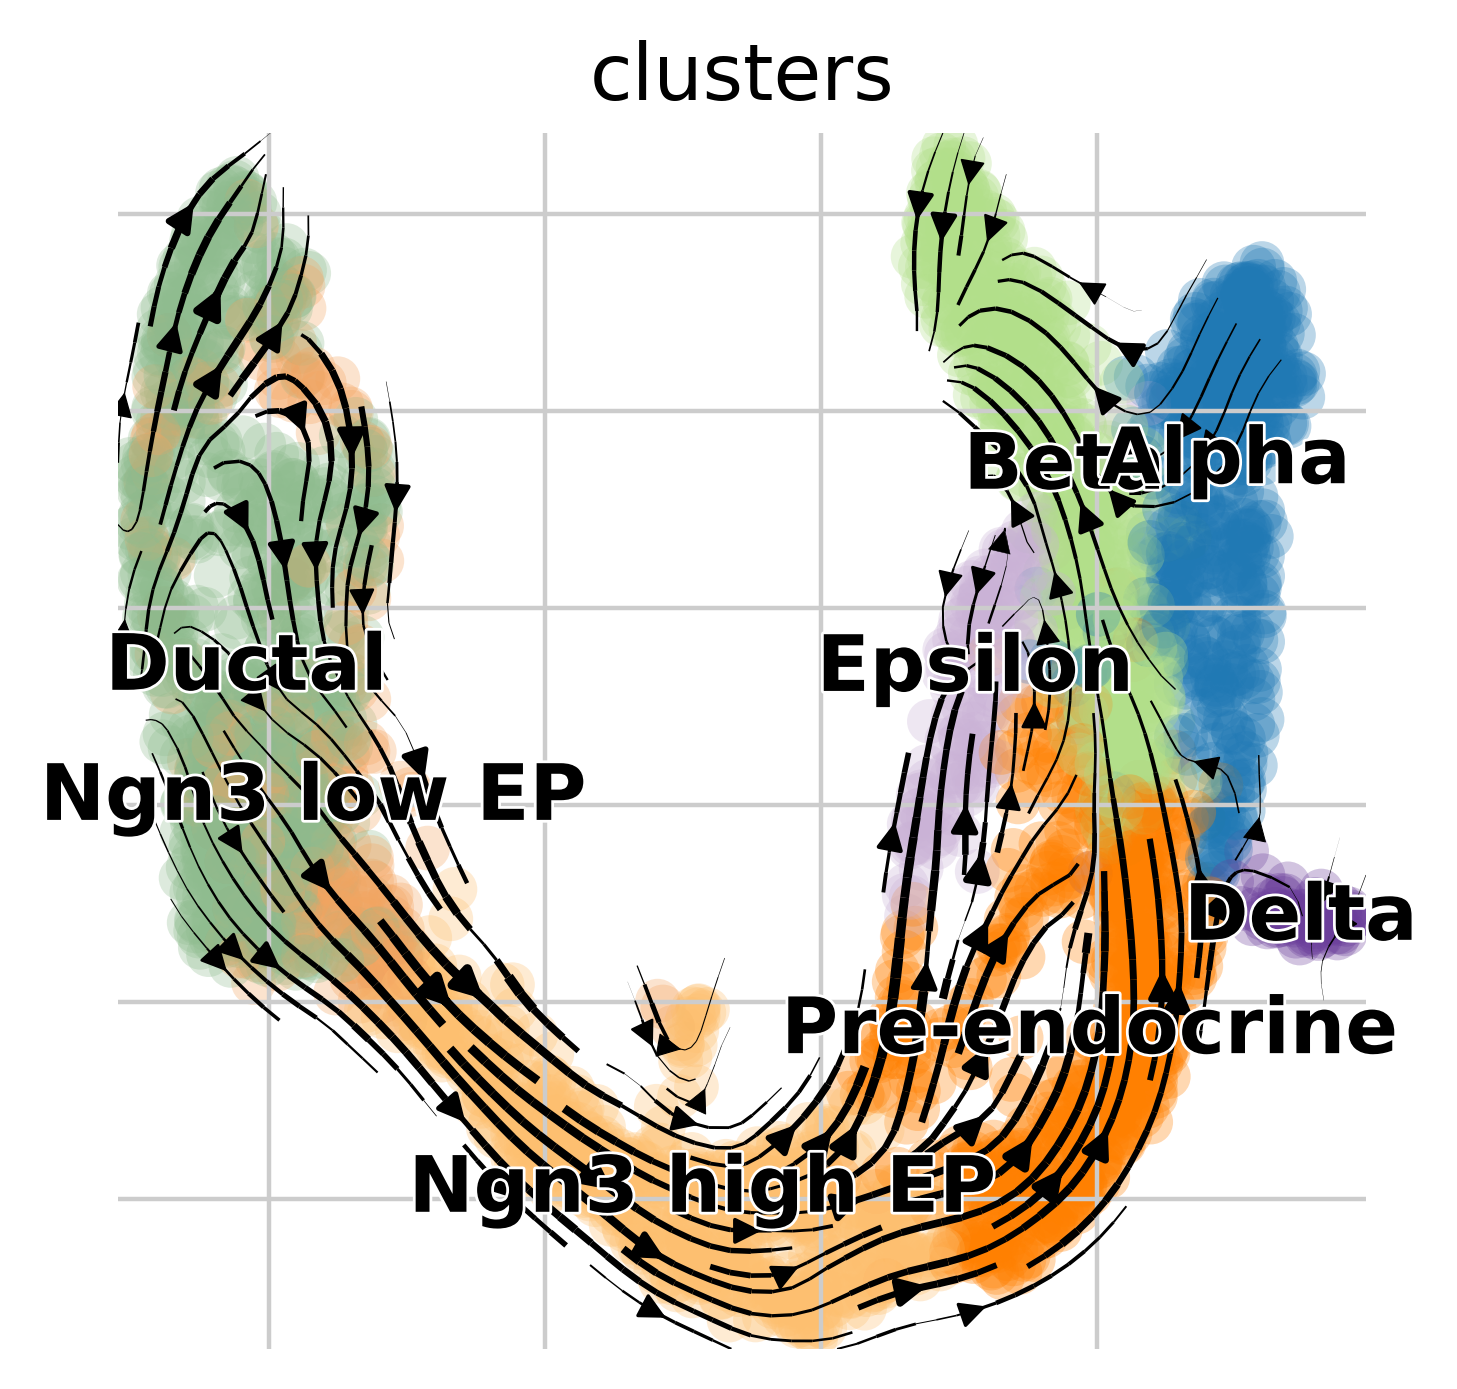

In [18]:
scv.pl.velocity_embedding_stream(adata, basis='umap', save="velocity_embedding")

Intrinsic uncertainty

In [19]:
uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=100)
uncertainty_df.head()

INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/chels/an

directional_variance  directional_difference  \
index                                                            
AAACCTGAGAGGGATA              0.003387                0.182226   
AAACCTGAGCCTTGAT              0.005017                0.232567   
AAACCTGAGGCAATTA              0.004597                0.242510   
AAACCTGCATCATCCC              0.004714                0.210303   
AAACCTGGTAAGTGGC              0.004365                0.202090   

                  directional_cosine_sim_variance  \
index                                               
AAACCTGAGAGGGATA                         0.001933   
AAACCTGAGCCTTGAT                         0.002823   
AAACCTGAGGCAATTA                         0.002484   
AAACCTGCATCATCCC                         0.002611   
AAACCTGGTAAGTGGC                         0.002411   

                  directional_cosine_sim_difference  \
index                                                 
AAACCTGAGAGGGATA                           0.135782   
AAACCTGAGCCTTGAT                           0.175187   
AAACCTGAGGCAATTA                           0.179326   
AAACCTGCATCATCCC                           0.155247   
AAACCTGGTAAGTGGC                           0.148144   

                  directional_cosine_sim_mean  
index                                          
AAACCTGAGAGGGATA                     0.666899  
AAACCTGAGCCTTGAT                     0.657598  
AAACCTGAGGCAATTA                     0.677766  
AAACCTGCATCATCCC                     0.676280  
AAACCTGGTAAGTGGC                     0.676280

In [20]:
for c in uncertainty_df.columns:
    adata.obs[c] = np.log10(uncertainty_df[c].values)

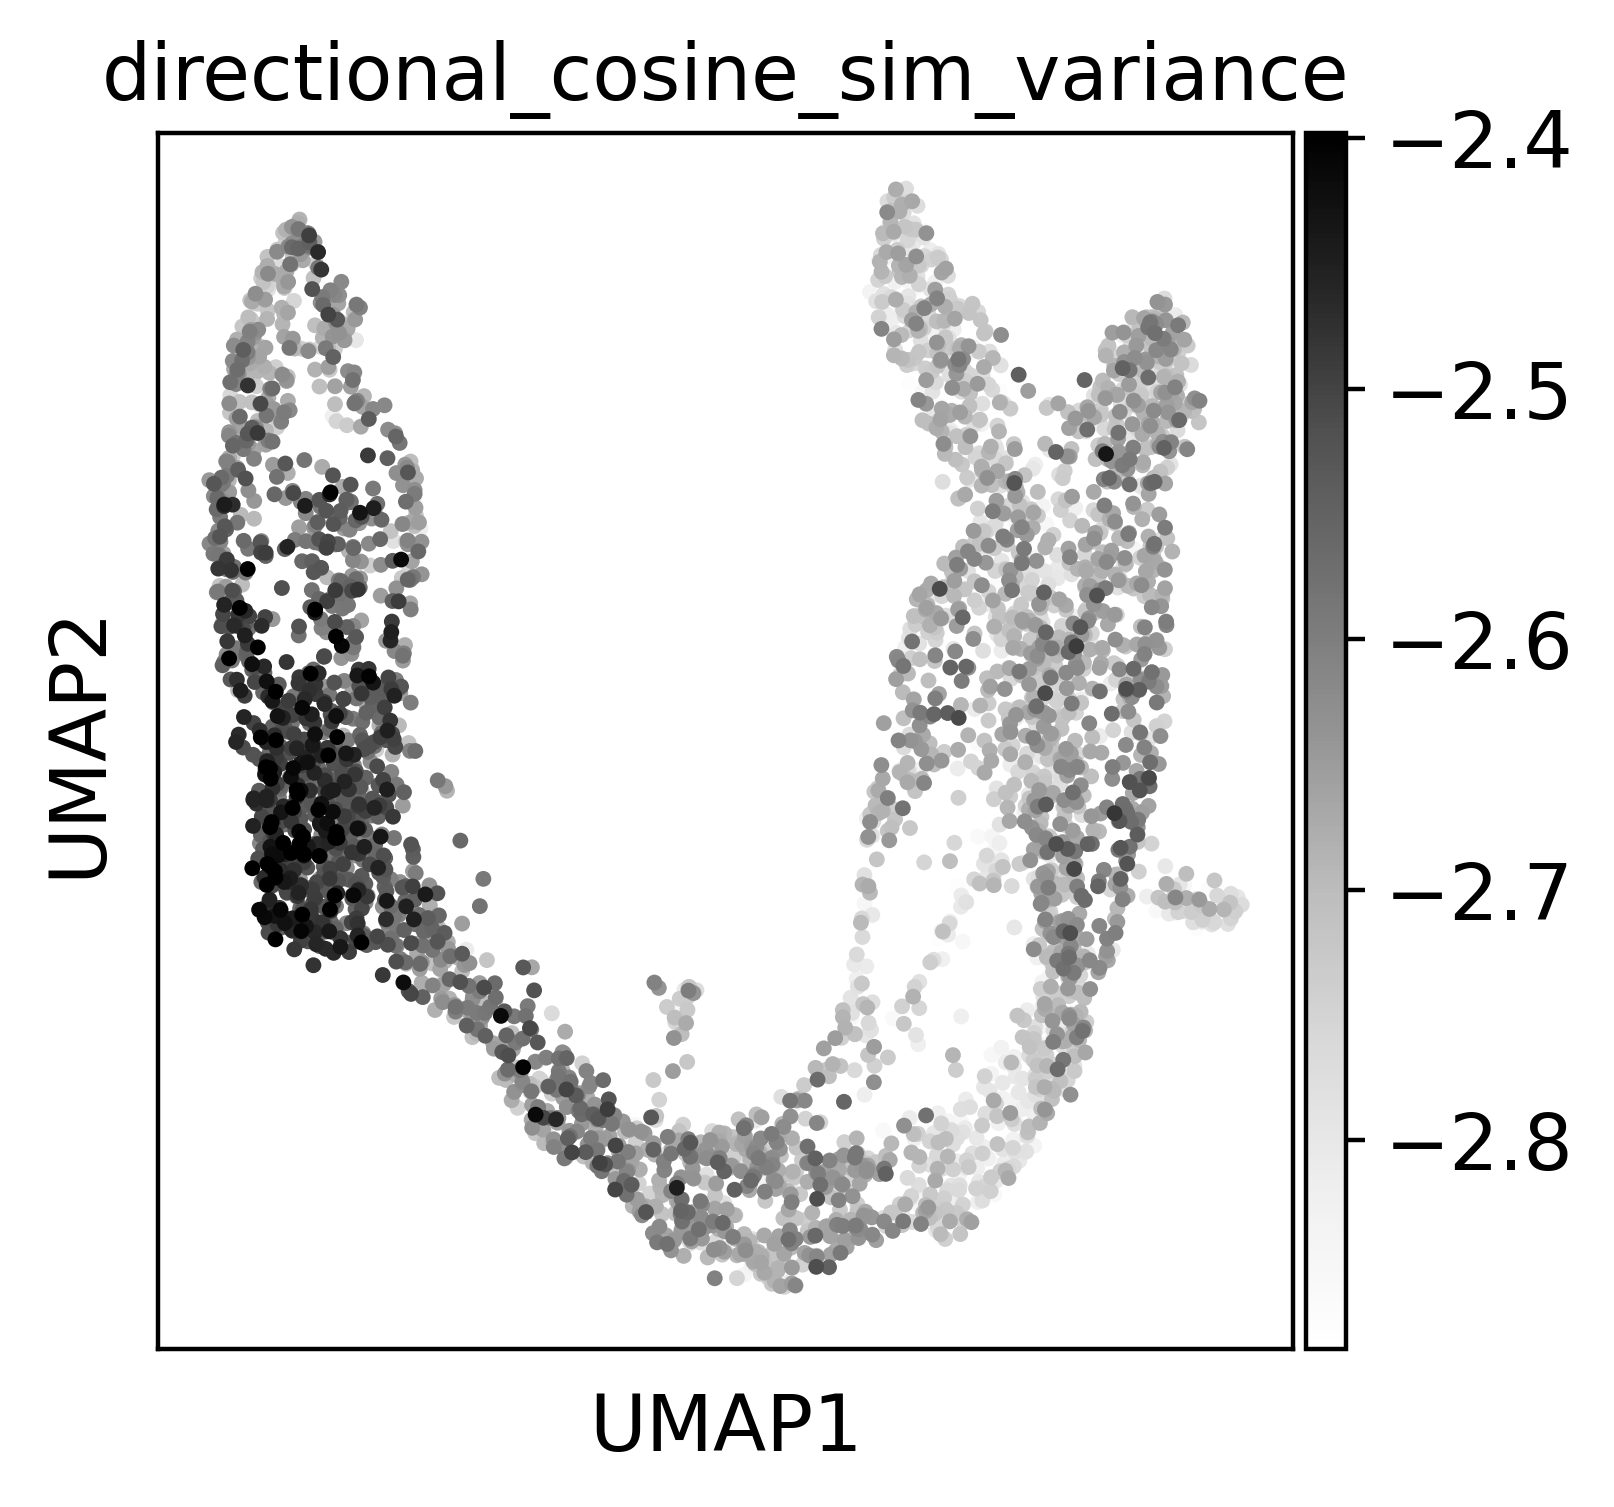

In [22]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance",
    cmap="Greys",
    vmin="p1",
    vmax="p99",
    save="intrinsic_uncertainty.png"
)

Extrinsic uncertainty

In [23]:
def compute_extrinisic_uncertainty(adata, vae, n_samples=25) -> pd.DataFrame:
    from velovi._model import _compute_directional_statistics_tensor
    from scvi.utils import track
    from contextlib import redirect_stdout
    import io

    extrapolated_cells_list = []
    for i in track(range(n_samples)):
        with io.StringIO() as buf, redirect_stdout(buf):
            vkey = "velocities_velovi_{i}".format(i=i)
            v = vae.get_velocity(n_samples=1, velo_statistic="mean")
            adata.layers[vkey] = v
            scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=False, approx=True)
            t_mat = scv.utils.get_transition_matrix(
                adata, vkey=vkey, self_transitions=True, use_negative_cosines=True
            )
            extrapolated_cells = np.asarray(t_mat @ adata.layers["Ms"])
            extrapolated_cells_list.append(extrapolated_cells)
    extrapolated_cells = np.stack(extrapolated_cells_list)
    df = _compute_directional_statistics_tensor(extrapolated_cells, n_jobs=-1, n_cells=adata.n_obs)
    return df

In [24]:
ext_uncertainty_df = compute_extrinisic_uncertainty(adata, vae)

Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [01:02<25:07, 62.83s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [01:21<14:07, 36.85s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [01:38<10:12, 27.83s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [01:55<08:15, 23.58s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [02:14<07:14, 21.74s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [02:32<06:31, 20.59s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [02:51<05:59, 19.99s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [03:09<05:32, 19.55s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [03:59<07:40, 28.81s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [04:15<06:14, 24.96s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [04:32<05:14, 22.44s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [04:48<04:27, 20.55s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [05:04<03:51, 19.27s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [05:20<03:21, 18.34s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [05:37<02:57, 17.71s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [05:54<02:39, 17.67s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [06:11<02:19, 17.41s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [06:52<02:52, 24.61s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [07:10<02:14, 22.40s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [07:27<01:44, 20.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [07:44<01:19, 19.76s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [08:02<00:57, 19.15s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [08:19<00:37, 18.54s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [08:35<00:17, 17.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [08:52<00:00, 21.31s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/chels/an

In [36]:
for c in ext_uncertainty_df[0].columns:
    adata.obs[c + "_extrinsic"] = np.log10(ext_uncertainty_df[0][c].values)

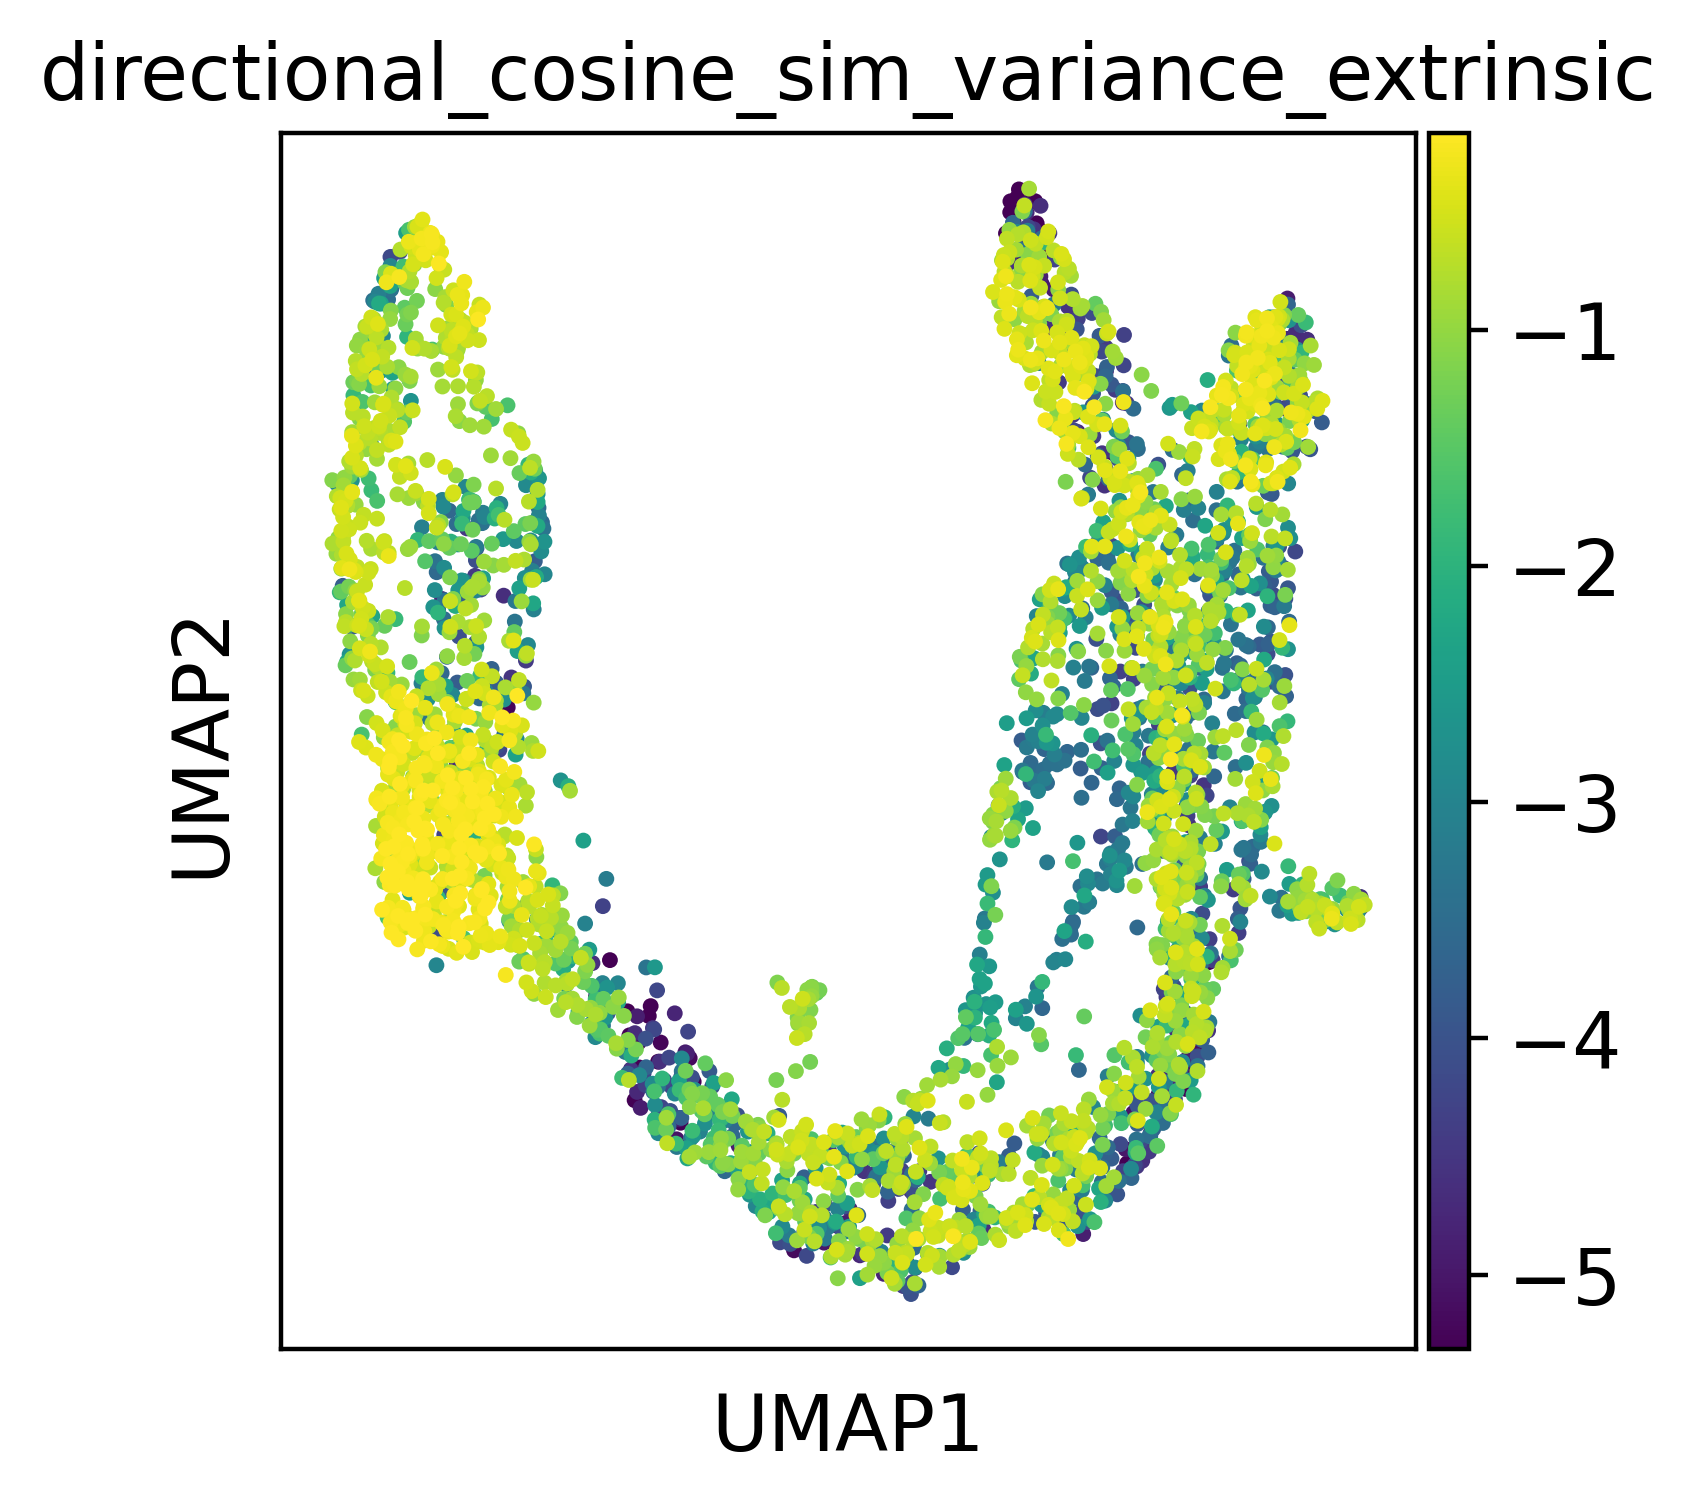

In [37]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance_extrinsic",
    vmin="p1", 
    vmax="p99", 
    save="extrinsic_uncertainty.png"
)

Permutation score

In [38]:
perm_df, _ = vae.get_permutation_scores(labels_key="clusters")
adata.var["permutation_score"] = perm_df.max(1).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


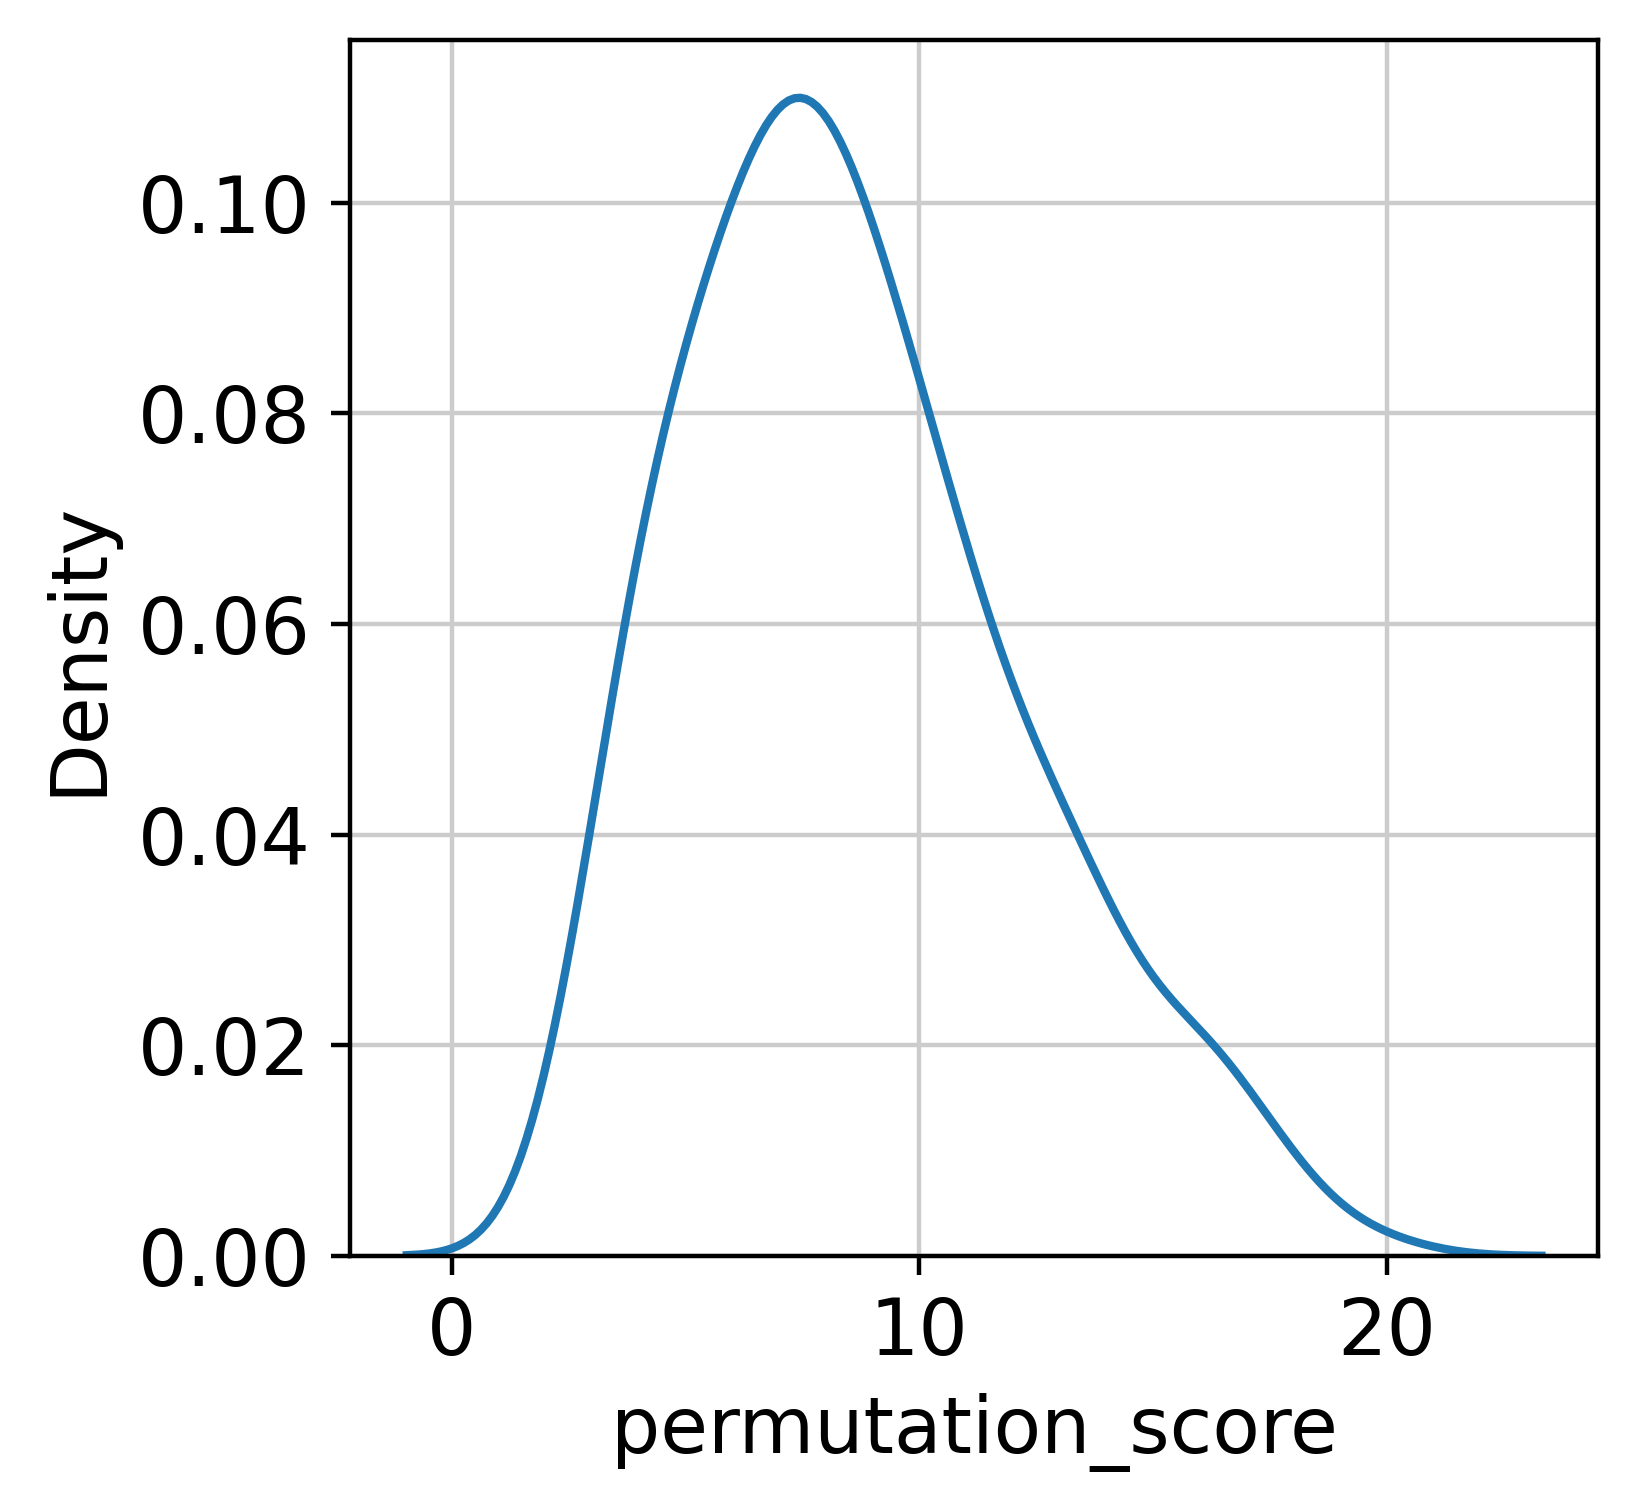

In [42]:
perm_score=sns.kdeplot(data=adata.var, x="permutation_score")
perm_score_fig=perm_score.get_figure()
perm_score_fig.savefig("figures/permutation_score.png") 

In [ ]:
#Sunday
#run without soft mask
#check if GPs are decreasing (look at GPs not included in original pancreas app to expimap)
#get latent directions
#plot GPs
#Compare with orig velovi

#Monday
#Apply other decoder
